In [1]:
!pip install patchify
!pip install -q monai

In [4]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
import torch

import torch

cuda_available = torch.cuda.is_available()
if cuda_available:
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
torch.cuda.get_device_name(0)

'Tesla V100-PCIE-32GB'

In [6]:
!nvidia-smi

Fri Dec 15 11:46:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:0A:00.0 Off |                    0 |
| N/A   25C    P0    23W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
     

In [4]:
import os

# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = ""
IMAGES_PATH = os.path.sep.join([BASE_PATH, "water_v1/water_v1/JPEGImages"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "./water_v1/water_v1/Annotations"])

# define the path to the base output directory
BASE_OUTPUT = "shm-wind-turbines"

# # define the path to the output model, label binarizer, plots output directory and testing image paths
# MODEL_PATH ="/kaggle/working/detector.h5"
# LB_PATH = "/kaggle/working/modelv5light\lb.pickle"
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])


# initialize our initial learning rate, number of epochs to train for and the batch size
INIT_LR = 1e-3
NUM_EPOCHS = 10
BATCH_SIZE = 64

In [8]:
import os

# Define the root directory of your dataset
dataset_root = "./water_v1/water_v1"

# Create lists to store image and annotation file paths
image_paths = []
annotation_paths = []

# Define the subfolders for images and annotations
image_subfolder = "JPEGImages/ADE20K"
annotation_subfolder = "Annotations/ADE20K"

# Traverse the dataset directory and its subfolders
# for root, dirs, files in os.walk(dataset_root):
#     # Check if the current directory is an image subfolder
#     if image_subfolder in root:
#         # Iterate through image files
#         for filename in files:
#             if filename.endswith(".png"):
#                 image_path = os.path.join(root, filename)
#                 # Create the corresponding annotation path
#                 annotation_path = image_path.replace(image_subfolder, annotation_subfolder)
#                 annotation_path = annotation_path.replace(".png", ".png")

#                 # Append the paths to the lists
#                 image_paths.append(image_path)
#                 annotation_paths.append(annotation_path)
for root, dirs, files in os.walk(dataset_root):
            # Check if the current directory is an image subfolder
            if image_subfolder in root:
                # Iterate through image files
                for filename in files:
                    if filename.endswith(".png"):
                        image_path = os.path.join(root, filename)
                        # Create the corresponding annotation path
                        annotation_path = image_path.replace(image_subfolder, annotation_subfolder)
                        annotation_path = annotation_path.replace(".png", ".png")

                        # Append the paths to the lists
                        if os.path.exists(annotation_path):  # Check if annotation file exists
                            image_paths.append(image_path)
                            annotation_paths.append(annotation_path)
                        else:
                            print(f"Warning: Annotation file not found for image {image_path}")

# Verify if the lengths of image_paths and annotation_paths are the same
if len(image_paths) != len(annotation_paths):
    print("Warning: Mismatch between the number of images and annotations.")

# Now, you have two lists containing image and annotation file paths
# image_paths contains the paths to the image files
# annotation_paths contains the paths to the annotation (mask) files


In [9]:
from datasets import Dataset
from PIL import Image
import numpy as np

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(256, 256), dtype=np.uint8):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img, dtype=dtype)
#     img = np.squeeze(img, axis=2)  # axis=2 is channel dimension
#     img = img[:, :, 0:1]
    return img


# Function to load and preprocess an annotation
def load_and_preprocess_annotation(annotation_path, target_size=(256, 256), dtype=np.uint8):
    ann = Image.open(annotation_path)
    ann = ann.resize(target_size)
    ann = np.array(ann, dtype=dtype) / 255
    # Ensure the shape has only one channel (1)
#     ann = np.squeeze(ann, axis=2) 
#     ann = ann[:, :, 0:1]
    return ann



# Create lists to store image and annotation data
images = []
annotations = []

# Load and preprocess images
for image_path in image_paths:
    img = load_and_preprocess_image(image_path)
    images.append(img)

# Load and preprocess annotations
for annotation_path in annotation_paths:
    ann = load_and_preprocess_annotation(annotation_path)
    annotations.append(ann)

# Convert lists to NumPy arrays
images = np.array(images, dtype=np.uint8)
annotations = np.array(annotations, dtype=np.uint8)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img,'RGB') for img in images],
    "label": [Image.fromarray(ann,'RGB') for ann in annotations],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


/usr/local/lib/python3.8/dist-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [10]:
images.shape

(1889, 256, 256, 3)

In [11]:
annotations.shape

(1889, 256, 256, 3)

In [9]:
import numpy as np

# Assuming you have 'images' and 'annotations' as (2167, 256, 256, 3) arrays
# You can remove the last dimension (3) like this:

images = images[:, :, :, 0]  # This keeps only the red channel
annotations = annotations[:, :, :, 0]  # This keeps only the red channel

# Now 'images' and 'annotations' will be (2167, 256, 256) arrays.


In [10]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img,'L') for img in images],
    "label": [Image.fromarray(ann,'L') for ann in annotations],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [11]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1889
})

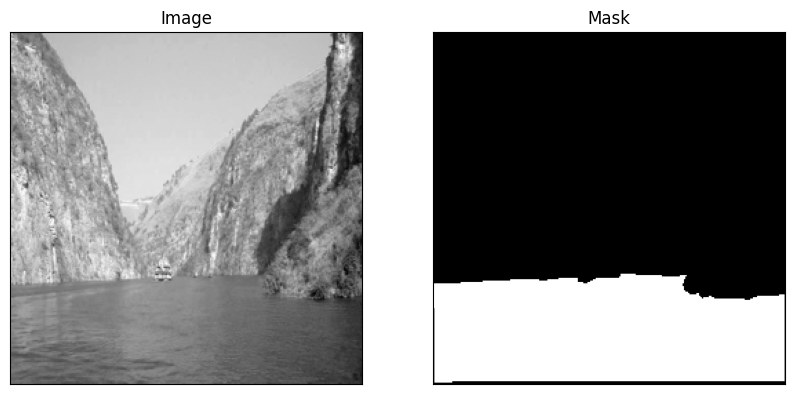

In [25]:
import random
import matplotlib.pyplot as plt

img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [15]:
# #Get bounding boxes from mask.
# def get_bounding_box(ground_truth_map):
#     # get bounding box from mask
#     y_indices, x_indices = np.where(ground_truth_map > 0)
#     x_min, x_max = np.min(x_indices), np.max(x_indices)
#     y_min, y_max = np.min(y_sindices), np.max(y_indices)
#     # add perturbation to bounding box coordinates
#     H, W = ground_truth_map.shape
#     x_min = max(0, x_min - np.random.randint(0, 20))
#     x_max = min(W, x_max + np.random.randint(0, 20))
#     y_min = max(0, y_min - np.random.randint(0, 20))
#     y_max = min(H, y_max + np.random.randint(0, 20))
#     bbox = [x_min, y_min, x_max, y_max]

#     return bbox
# def get_bounding_box(ground_truth_map):
#     x_indices, y_indices = np.where(ground_truth_map > 0)
#     if len(x_indices) == 0:
#         # Handle the case where there are no non-zero values in the map
#         return 0, 0, 0, 0

#     x_min, x_max = np.min(x_indices), np.max(x_indices)
#     y_min, y_max = np.min(y_indices), np.max(y_indices)

#     # Add perturbation to bounding box coordinates
#     H, W = ground_truth_map.shape  # Access the height (H) and width (W)
#     x_min = max(0, x_min - np.random.randint(0, 20))
#     x_max = min(W, x_max + np.random.randint(0, 20))
#     y_min = max(0, y_min - np.random.randint(0, 20))
#     y_max = min(H, y_max + np.random.randint(0, 20))
    
#     input_boxes = [[[float(x_min), float(y_min), float(x_max), float(y_max)]]]

#     return input_boxes




In [26]:
import numpy as np

def get_bounding_box(ground_truth_map):
    # Check if the ground truth map is empty
    if np.sum(ground_truth_map) == 0:
        return [0, 0, ground_truth_map.shape[1], ground_truth_map.shape[0]]

    # Get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    # Add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [27]:

from torch.utils.data import Dataset

class SAMDataset(Dataset):
    
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])
        prompt = get_bounding_box(ground_truth_mask)
        inputs = self.processor(image,input_boxes=[[prompt]], return_tensors="pt")
    # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs


# from torch.utils.data import Dataset

# class SAMDataset(Dataset):
    
#     """
#     This class is used to create a dataset that serves input images and masks.
#     It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
#     """
#     def __init__(self, dataset, processor):
#         self.dataset = dataset
#         self.processor = processor
#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         item = self.dataset[idx]
#         image = item["image"]
#         ground_truth_mask = np.array(item["label"])
#         prompt = get_bounding_box(ground_truth_mask)
        
#         # Check if prompt is empty (i.e., no non-zero values in the map)
#         if not prompt:
#             return None  # Skip this data point
            
#         print(f"input_boxes: {prompt}")
#         inputs = self.processor(image, input_boxes=[prompt], return_tensors="pt")
        
#         # remove batch dimension which the processor adds by default
#         inputs = {k: v.squeeze(0) for k, v in inputs.items()}
    
#         # add ground truth segmentation
#         inputs["ground_truth_mask"] = ground_truth_mask
    
#         return inputs
    
    # def __getitem__(self, idx):
    #     item = self.dataset[idx]
    #     image = item["image"]
    #     ground_truth_mask = np.array(item["label"])
    #     prompt = get_bounding_box(ground_truth_mask)
    #     print(f"input_boxes: {prompt}")
    #     inputs = self.processor(image,input_boxes=[prompt], return_tensors="pt")
    # # remove batch dimension which the processor adds by default
    #     inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # # add ground truth segmentation
    #     inputs["ground_truth_mask"] = ground_truth_mask

    #     return inputs



In [28]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# from transformers import SamModel, SamProcessor

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
# processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# # Initialize the processor
# from transformers import SamProcessor, AutoConfig
# config = AutoConfig.from_pretrained("facebook/sam-vit-base")
# processor = SamProcessor.from_config(config)

# from transformers import (
#     SamVisionConfig,
#     SamPromptEncoderConfig,
#     SamMaskDecoderConfig,
#     SamModel,
# )

# # Initializing a SamConfig with `"facebook/sam-vit-huge"` style configuration
# configuration = SamConfig()
# # Initializing a SamModel (with random weights) from the `"facebook/sam-vit-huge"` style configuration
# processor = SamModel(configuration)

In [29]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [30]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [31]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [32]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [33]:
# Load the model
from transformers import SamModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)
     

In [34]:
from torch.optim import Adam
from monai.losses import DiceCELoss

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


In [35]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [36]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import torch.nn as nn
#Training loop
num_epochs = 50

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()


for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

      # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [38]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import torch.nn as nn
#Training loop
num_epochs = 70

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= nn.DataParallel(model)
model.to(device)
model.train()
scaler = GradScaler()

for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        with autocast():
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


100%|██████████| 945/945 [05:32<00:00,  2.85it/s]


EPOCH: 0
Mean loss: 0.3204376179468695


100%|██████████| 945/945 [05:30<00:00,  2.86it/s]


EPOCH: 1
Mean loss: 0.2823028448279257


100%|██████████| 945/945 [05:30<00:00,  2.86it/s]


EPOCH: 2
Mean loss: 0.27308993559113887


100%|██████████| 945/945 [05:28<00:00,  2.88it/s]


EPOCH: 3
Mean loss: 0.2621367961720184


100%|██████████| 945/945 [05:29<00:00,  2.87it/s]


EPOCH: 4
Mean loss: 0.256569385362996


100%|██████████| 945/945 [05:27<00:00,  2.89it/s]


EPOCH: 5
Mean loss: 0.25341602878832314


100%|██████████| 945/945 [05:26<00:00,  2.90it/s]


EPOCH: 6
Mean loss: 0.24175905980288037


100%|██████████| 945/945 [05:27<00:00,  2.89it/s]


EPOCH: 7
Mean loss: 0.2360841925714224


100%|██████████| 945/945 [05:24<00:00,  2.91it/s]


EPOCH: 8
Mean loss: 0.23311631650954642


100%|██████████| 945/945 [05:27<00:00,  2.88it/s]


EPOCH: 9
Mean loss: 0.22761860686950583


100%|██████████| 945/945 [05:24<00:00,  2.92it/s]


EPOCH: 10
Mean loss: 0.23006766915479035


100%|██████████| 945/945 [05:27<00:00,  2.89it/s]


EPOCH: 11
Mean loss: 0.22308352117342925


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 12
Mean loss: 0.21344628841591576


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 13
Mean loss: 0.21522487917589764


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 14
Mean loss: 0.21489041205791254


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 15
Mean loss: 0.20705467346838857


100%|██████████| 945/945 [05:28<00:00,  2.88it/s]


EPOCH: 16
Mean loss: 0.20228239616783208


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 17
Mean loss: 0.20418592468101196


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 18
Mean loss: 0.19691467963198506


100%|██████████| 945/945 [05:27<00:00,  2.88it/s]


EPOCH: 19
Mean loss: 0.19331671957064558


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 20
Mean loss: 0.19302992707995512


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 21
Mean loss: 0.19097034446895123


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 22
Mean loss: 0.18981407875264134


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 23
Mean loss: 0.1870445319742122


100%|██████████| 945/945 [05:26<00:00,  2.90it/s]


EPOCH: 24
Mean loss: 0.18132385324351685


100%|██████████| 945/945 [05:25<00:00,  2.91it/s]


EPOCH: 25
Mean loss: 0.19015723949189856


100%|██████████| 945/945 [05:26<00:00,  2.90it/s]


EPOCH: 26
Mean loss: 0.1783301477217012


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 27
Mean loss: 0.17756062935466174


100%|██████████| 945/945 [05:26<00:00,  2.90it/s]


EPOCH: 28
Mean loss: 0.1760572695779422


100%|██████████| 945/945 [05:27<00:00,  2.89it/s]


EPOCH: 29
Mean loss: 0.17691124944538666


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 30
Mean loss: 0.17321530569679838


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 31
Mean loss: 0.17017810762165084


100%|██████████| 945/945 [05:26<00:00,  2.90it/s]


EPOCH: 32
Mean loss: 0.17196298203968183


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 33
Mean loss: 0.17576532373943973


100%|██████████| 945/945 [05:24<00:00,  2.91it/s]


EPOCH: 34
Mean loss: 0.1712804368209271


100%|██████████| 945/945 [05:27<00:00,  2.89it/s]


EPOCH: 35
Mean loss: 0.16585831123369713


100%|██████████| 945/945 [05:26<00:00,  2.90it/s]


EPOCH: 36
Mean loss: 0.16673554493084786


100%|██████████| 945/945 [05:28<00:00,  2.87it/s]


EPOCH: 37
Mean loss: 0.16546475471209282


100%|██████████| 945/945 [05:26<00:00,  2.90it/s]


EPOCH: 38
Mean loss: 0.15964890115712055


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 39
Mean loss: 0.1607396543893234


100%|██████████| 945/945 [05:25<00:00,  2.91it/s]


EPOCH: 40
Mean loss: 0.15801071796034064


100%|██████████| 945/945 [05:26<00:00,  2.90it/s]


EPOCH: 41
Mean loss: 0.15957934868044008


100%|██████████| 945/945 [05:28<00:00,  2.88it/s]


EPOCH: 42
Mean loss: 0.1588027262281646


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 43
Mean loss: 0.15568521668513616


100%|██████████| 945/945 [05:26<00:00,  2.90it/s]


EPOCH: 44
Mean loss: 0.15695218192364174


100%|██████████| 945/945 [05:26<00:00,  2.90it/s]


EPOCH: 45
Mean loss: 0.1547369503923667


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 46
Mean loss: 0.1513181297216939


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 47
Mean loss: 0.1504448019736816


100%|██████████| 945/945 [05:29<00:00,  2.87it/s]


EPOCH: 48
Mean loss: 0.15121376590911673


100%|██████████| 945/945 [05:34<00:00,  2.82it/s]


EPOCH: 49
Mean loss: 0.14967670263870367


100%|██████████| 945/945 [05:33<00:00,  2.84it/s]


EPOCH: 50
Mean loss: 0.14826756321958134


100%|██████████| 945/945 [05:30<00:00,  2.86it/s]


EPOCH: 51
Mean loss: 0.14604317855937457


100%|██████████| 945/945 [05:27<00:00,  2.89it/s]


EPOCH: 52
Mean loss: 0.1461863576912533


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 53
Mean loss: 0.1479529462478779


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 54
Mean loss: 0.1449135191718895


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 55
Mean loss: 0.14231407552681588


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 56
Mean loss: 0.13896273012475047


100%|██████████| 945/945 [05:24<00:00,  2.91it/s]


EPOCH: 57
Mean loss: 0.1396250867812091


100%|██████████| 945/945 [05:24<00:00,  2.92it/s]


EPOCH: 58
Mean loss: 0.14078420759745375


100%|██████████| 945/945 [05:27<00:00,  2.89it/s]


EPOCH: 59
Mean loss: 0.14079045552228178


100%|██████████| 945/945 [05:25<00:00,  2.91it/s]


EPOCH: 60
Mean loss: 0.13934460037520954


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 61
Mean loss: 0.13754284334364075


100%|██████████| 945/945 [05:26<00:00,  2.90it/s]


EPOCH: 62
Mean loss: 0.13598263953768072


100%|██████████| 945/945 [05:27<00:00,  2.89it/s]


EPOCH: 63
Mean loss: 0.13503900513880782


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 64
Mean loss: 0.13544585730230052


100%|██████████| 945/945 [05:27<00:00,  2.89it/s]


EPOCH: 65
Mean loss: 0.13385856049283157


100%|██████████| 945/945 [05:24<00:00,  2.91it/s]


EPOCH: 66
Mean loss: 0.13302231335214207


100%|██████████| 945/945 [05:25<00:00,  2.90it/s]


EPOCH: 67
Mean loss: 0.13574747031249065


100%|██████████| 945/945 [05:26<00:00,  2.89it/s]


EPOCH: 68
Mean loss: 0.1307613532201796


100%|██████████| 945/945 [05:27<00:00,  2.89it/s]

EPOCH: 69
Mean loss: 0.131658220525693


In [39]:
torch.save(model.state_dict(), "./checkpoint_sam_torch/wase_model_checkpoint2forcomparison.pth")

In [34]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [37]:
device = "cpu"

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_wase_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_wase_model.load_state_dict(torch.load("./checkpoint_sam_torch/wase_model_checkpoint.pth"))


In [3]:
# set the device to cuda if available, otherwise use cpu
device = "cpu" if torch.cuda.is_available() else "cpu"
my_wase_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0): SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
      (1): SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Line

In [4]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_wase_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_wase_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

NameError: name 'images' is not defined

SamImageSegmentationOutput(iou_scores=tensor([[[0.9838]]]), pred_masks=tensor([[[[[-2.6385, -2.1188, -2.1034,  ..., -4.6083, -4.8202, -4.9652],
           [-2.7489, -2.1282, -1.9363,  ..., -4.6990, -5.1001, -5.0360],
           [-3.0505, -2.5510, -2.5919,  ..., -4.5685, -5.2133, -5.1053],
           ...,
           [-3.3927,  0.1554,  0.7796,  ..., -6.7595, -6.0236, -5.8985],
           [-3.1075,  0.0533, -0.2497,  ..., -6.4399, -5.5365, -5.6131],
           [-3.6861, -1.2747, -1.3882,  ..., -6.6209, -6.4220, -6.2102]]]]]), vision_hidden_states=None, vision_attentions=None, mask_decoder_attentions=None)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


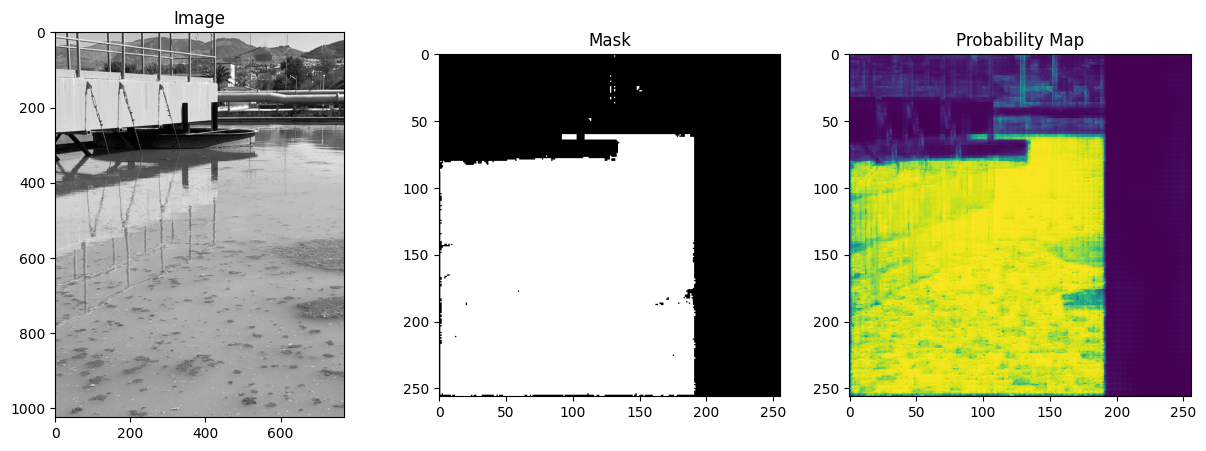

In [8]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Load a normal image (you need to specify the path to your image)
normal_image_path = "./images/water_images/WhatsApp Görsel 2023-09-25 saat 17.24.05.jpg"
test_image = Image.open(normal_image_path)
test_image = test_image.convert("L")
# Get the box prompt based on the image size (you may need to adjust this based on your use case)
prompt = [0, 0, test_image.width, test_image.height]

# # Prepare the image + box prompt for the model
# inputs = processor(test_image, input_boxes=[prompt], return_tensors="pt")
# Modify the prompt to be in the expected format
prompt = [[prompt]]  # Wrap it in an extra list

# Prepare the image + box prompt for the model
inputs = processor(test_image, input_boxes=prompt, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

# Set the model to evaluation mode
my_wase_model.eval()

# Forward pass
with torch.no_grad():
    outputs = my_wase_model(**inputs, multimask_output=False)
print(outputs)
# Apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# Convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
print(medsam_seg)
# Create a figure for plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image on the left
axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Image")

# Plot the segmentation mask in the middle
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Mask")

# Plot the probability map on the right
axes[2].imshow(medsam_seg_prob, cmap='viridis')  # You can choose a different colormap
axes[2].set_title("Probability Map")

# # Hide axis ticks and labels
# for ax in axes:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# Display the images side by side
plt.show()


In [114]:
medsam_seg.shape

(256, 256)

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# Define the show_box function to display a single box
def show_box(box, ax):
    x0, y0, w, h = box  # Unpack the box coordinates
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor='none', lw=2))

# Define the show_boxes_on_image function
def show_boxes_on_image(image, boxes):
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        show_box(box, ax)
    plt.axis('on')
    plt.show()


In [126]:
prompt

[192, 25, 255, 69]

In [127]:
resized_image = cv2.resize(np.array(test_image), (190, 250), interpolation=cv2.INTER_LINEAR)

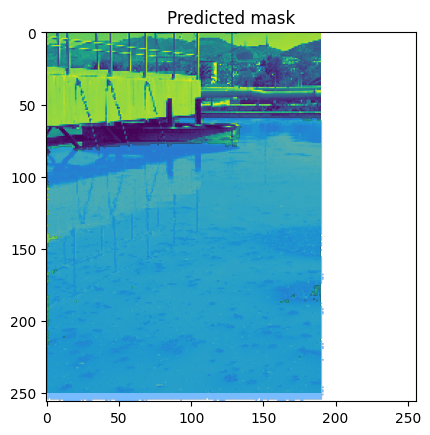

In [118]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(resized_image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
# axes.axis("off")